# Mini Generative Pretrained Transformer-1 (mGPT-1)

This notebook illustrates a basic implementation of the Generative Pretrained Transformer model using PyTorch. We follow a similar approach as described in the original [GPT-1 paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). Further details about the model architecture will be provided in the Mini GPT Architecture section. The specific sections covered in this notebook are:

1. Data Downloading and Normalization
2. Training Custom Tokenizer
3. wikipedia Pages Splitting
4. Building Custom Dataset and Data Loader
5. Mini GPT Architecture

**Introduction**

One of the most well-known successes of transformer-based language models has been text generation with the GPT-2, GPT-3, and GPT-4 language models, which are built from stacks of transformer-decoder layers. GPT (Generative Pre-training) is a family of generative pre-training models that are part of the language modeling trend where a model is first trained on unsupervised data, in a task-agnostic fashion, and later fine-tuned for a specific task. The first model in this family, the eponymous [GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), pre-trains a stack of transformer decoder layers on a large body of unlabeled text and is then fine-tuned on labeled, task-specific data. GPT is an autoregressive model, which means it uses inputs from previous steps of a sequence to predict values later in the sequence.

Different from the original implementation of the first [GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), here we will not fine-tune the model on a downstream task; we will focus only on the unsupervised pre-training phase. Another important change is that we will use the [Byte-Pair Encoding Tokenizer](https://github.com/omarcastano/solo-learning-nlp/blob/main/self-supervised/Byte_Pair_Encoding_tokenization.ipynb) instead of the SpaCy tokenizer as done in the original paper.


**Unsupervised pre-training**: In this phase, **GPT** starts with a corpus of tokens and, moving through it, learns how to predict the next token, given some preceding context. More formally, given an unlabeled corpus of tokens $X = \{x_1, \ldots, x_n\}$, the model learns the conditional probability of predicting token $x_t$ given the preceding $k$ tokens $P(x_t | x_{t-1}, \ldots, x_{t-k})$ by minimizing the negative log-likelihood

$$L(X) = -\sum_t \log P(x_t | x_{t-1}, \ldots, x_{t-k}; \Theta)$$


the conditional probability $P$ is modeled using a neural network with $\Theta$ represents the model parameters.

The neural network model applies a multi-headed self-attention operation over the input context tokens followed by position-wise feedforward layers to produce an output distribution over target tokens:



<div style="text-align: center;">
    <img src="https://i.imgur.com/dMO2Dtq.png" alt="" width="800px" height="500px">
</div>

Where $W_e$ and $W_p$ are the token and positional embedding matrices respectively. $W_f$ is a projection matrix to get the logits. `<s>` denotes the beginning of sentence token and `</s>` denotes the end of sentence token.



In [1]:
# black formatting with jupyter-black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=170,
)

## Data Preparation

We will use the [Wikipedia dataset](https://huggingface.co/datasets/bookcorpus/bookcorpus) to pre-train our Mini GPT model. This dataset is approximately 20GB in size, so please grab a coffee while the data is being downloaded.


In [2]:
# import load_dataset
from datasets import load_dataset

We will not be using the entire dataset due to the extended training time it would require. Instead, we will work with a smaller portion of the original dataset. Feel free to adjust the amount of data used for training.


In [3]:
# load de dataset
data = load_dataset("wikipedia", "20220301.en", split="train[0:500]", trust_remote_code=True).to_pandas()
# data = load_dataset("karpathy/tiny_shakespeare", split="train", trust_remote_code=True).to_pandas()

Next, we define a basic data pre-processing function that handles text normalization.

In [4]:
import re
import string


# Basic preprocessing.
def text_preprocessing(text: str) -> str:

    # to lower
    text = text.lower()

    # remove number
    text = re.sub(r"\d+", "", text)

    # remove html tags
    text = re.sub(r"<.*?>", "", text)

    # remove urls
    text = re.sub(r"https?://\S+", "", text)

    # remove white spaces at the start and the end
    text = text.strip()

    return text

In [5]:
# apply text normalization
data.text = data.text.apply(text_preprocessing)
data.head()

,id,url,title,text
0,12,https://en.wikipedia.org/wiki/Anarchism,Anarchism,anarchism is a political philosophy and moveme...
1,25,https://en.wikipedia.org/wiki/Autism,Autism,autism is a neurodevelopmental disorder charac...
2,39,https://en.wikipedia.org/wiki/Albedo,Albedo,albedo (; ) is the measure of the diffuse refl...
3,290,https://en.wikipedia.org/wiki/A,A,"a, or a, is the first letter and the first vow..."
4,303,https://en.wikipedia.org/wiki/Alabama,Alabama,alabama () is a state in the southeastern regi...


## Training Custom Tokenizer 

In previous notebooks, we have implemented a [Byte-Pair Encoding Tokenizer](https://github.com/omarcastano/solo-learning-nlp/blob/main/self-supervised/Byte_Pair_Encoding_tokenization.ipynb) using only NumPy. However, this Python implementation is quite slow, so we will use the Transformers implementation of the Byte-Pair Encoding Tokenizer to save some time.


In [6]:
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import ByteLevel
import pandas as pd
from tokenizers import decoders

We will use the following special tokens:

- `<unk>`: Unknown token
- `<s>`: Start of sentence token
- `</s>`: End of sentence token

For the pre-tokenizer, we will use `ByteLevel`, which is very similar to the pre-tokenizer used in the GPT-2 tokenizer.

In [7]:
# Initialize tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))

# setting pre-tokenization to ByteLevel this is similar to gpt2 tokenizer
tokenizer.pre_tokenizer = ByteLevel()

# tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()

# Initialize a trainer with desired parameters
vocab_size = 40000
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>", "<s>", "</s>"])

# Load your training data into a list of strings
train_data = data.text.tolist()

# Train the tokenizer
tokenizer.train_from_iterator(
    train_data,
    trainer=trainer,
)

In [8]:
# quick tokenizer test
tokenizer.encode("she's buying a stairway to heaven!!").tokens

['Ġshe', "'s", 'Ġbuying', 'Ġa', 'Ġstair', 'way', 'Ġto', 'Ġheaven', '!!']

In [9]:
# count number of tokens per instance
data["text_length"] = data.text.apply(lambda x: len(tokenizer.encode(x).tokens))
data.text_length.describe()

count      500.000000
mean      5033.860000
std       4534.856853
min         53.000000
25%       1529.750000
50%       4155.000000
75%       6669.000000
max      24670.000000
Name: text_length, dtype: float64

From the statistics show above we can se that dataset is composed of wikipedia pages with different lengths, varying from 53 tokens to 25256 with a median of 6834

<Axes: xlabel='text_length', ylabel='Count'>

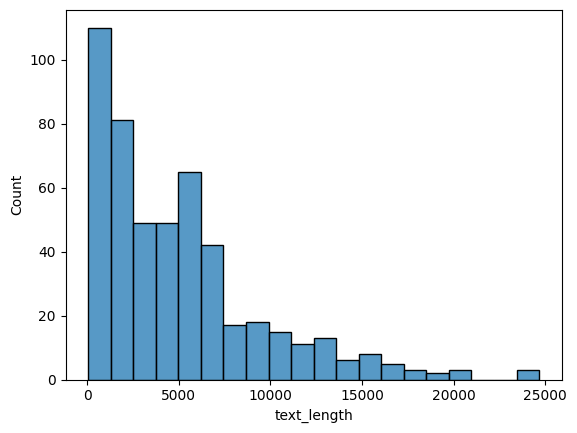

In [10]:
# plot number of words distribution#mini-gpt
import seaborn as sns

sns.histplot(data=data, x="text_length")

## wikipedia Pages Splitting

In order to prepare our data for causal language modeling, we need to split every Wikipedia page into segments no longer than a defined maximum sequence length (`max_seq_len`). For instance, consider a Wikipedia page with 53 tokens, and assume we set `max_seq_len=12`. This would result in dividing the page into 53//12=4 segments that can be fed into the model for training in batches. It's important to note that 53 divided by 12 equals to 4.416, but using the floor division operator (//) ensures integer division, allowing us to discard the final segment that doesn't reach 14 tokens without the need for padding tokens.

The original page containing 53 os the following:

**wikipedia_page**: ```trachysomus buquetii is a species of beetle in the family cerambycidae. it was described by james thomson in . it is known from argentina and brazil.\n\nreferences\n\nonciderini\nbeetles described in```

after splitting the wiki page into 4 segments of 12 tokens we end up with the following table of segments and tokens.

|    | text                                        | tokens                                                        |
|---:|:--------------------------------------------|:--------------------------------------------------------------|
|  0 | \<s>trachysomus buquetii is a species of\</s> | [1, 755, 226, 558, 218, 207, 815, 11019, 1103, 231, 168, 1378, 192, 2]  |
|  1 | \<s>beetle in the family cerambycidae. it was\</s>   | [1, 28906, 194, 172, 1274, 2701, 225, 1198, 33, 6433, 16, 269, 254, 2] |
|  2 | \<s>described by james thomson in . it is known from argentina and\</s> | [1, 1808, 260, 2429, 14373, 194, 351, 269, 231, 738, 307, 8602, 198, 2]  |
|  3 | \<s> brazil.\n\nreferences\n\nonciderini\n\</s>     | [1, 3959, 16, 132, 132, 1974, 132, 132, 174, 33, 764, 4105, 132, 2]    |


Notice that the remaining segment is given by **beetles described in** with only three tokens **[25259, 1808, 194]** so we discard this final segment.


In our implementation we will define `max_seq_len=128`, with the begin of sentence token `<s>` and end of sentence token `</s>` counting as part of the 128 token in each segment 

In [11]:
# Define max sequence length
max_seq_len = 128

split_tokens_ids = []
split_tokens = []

# In order to latter add being of sentence token (<s>) and end of sentence token (</s>), we subtract -2 to the max_seq_len
seq_len = max_seq_len - 2

# Iterate over the entire dataset and generate tokens ids
for id in range(len(data)):

    tokens = tokenizer.encode(data.text.tolist()[id]).ids

    for i in range(len(tokens) // seq_len):

        #  Adds the <s> and </s> to the sentences then encode into tokens ids and
        token_ids = tokenizer.encode("<s>").ids + tokens[i * seq_len : (i + 1) * seq_len] + tokenizer.encode("</s>").ids
        split_tokens_ids.append(token_ids)

        # decode tokens_ids
        decoded_tokens = tokenizer.decode(split_tokens_ids[i], skip_special_tokens=False)
        split_tokens.append(decoded_tokens)


# Create a pandas dataframe with the text and tokens ids
prepared_data = pd.DataFrame({"text": split_tokens, "tokens": split_tokens_ids})
print(prepared_data.shape)
prepared_data.head(10)

(19713, 2)


,text,tokens
0,<s> anarchism is a political philosophy and mo...,"[1, 4883, 231, 168, 1588, 2128, 198, 2359, 264..."
1,"<s> bodies, scepticism toward authority also r...","[1, 4539, 14, 20783, 3967, 4396, 3520, 402, 57..."
2,<s> movement has been resurgent once more.\n\n...,"[1, 2359, 418, 492, 472, 23322, 2351, 529, 16,..."
3,<s>the etymological origin of anarchism is fro...,"[1, 337, 21404, 1479, 192, 4883, 231, 307, 172..."
4,<s> but did not use anarchist or anarchism in ...,"[1, 427, 1222, 361, 732, 6655, 273, 4883, 194,..."
5,"<s>ologically disparate groups, including both...","[1, 9484, 26909, 1837, 14, 888, 856, 172, 497,..."
6,<s> and being both liberals and socialists but...,"[1, 198, 844, 856, 20390, 198, 24703, 427, 529..."
7,<s>\n\nhistory\n\npre-modern era \n\nbefore th...,"[1, 132, 132, 3113, 132, 132, 1186, 15, 4331, ..."
8,<s> myth of antigone to illustrate the conflic...,"[1, 2664, 192, 597, 244, 587, 206, 15123, 172,..."
9,"<s> abolition of monarchy, only to be soon exe...","[1, 9046, 192, 10754, 14, 648, 206, 242, 3300,..."


## Create Custom Dataset and Data Collator

Here we define our custom Dataset and Data Collator which in this case are very simple

In [12]:
# import Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader
import torch

In [13]:
# create custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        tokens_ids = self.data.tokens.iloc[idx]
        tokens_ids = torch.LongTensor(tokens_ids)

        return tokens_ids

**Data Collator**: In our implementation the data collator is very simple but at the same time very important because we will use it to generate the attention masks. The following is a description of how we generate the attention mask and why they are important in causal language modeling. For more details about the Transformer and self-attention mechanism, visit the [NMT with transformers notebook]().


In causal language modeling, such as in GPT, the attention mask is crucial for ensuring that during training the model attends only to previous tokens during generation and not to tokens that come after in the sequence. For instance, consider the sentence: **"I love reading notebooks to learn about transformers"**. 

To predict the token **"learn"**, we want the model to only have access to the preceding tokens **"I love reading notebooks to"**. This behavior is controlled using the attention mask.

<div style="text-align: center;">
    <img src="https://i.imgur.com/bFbKM3Q.png" alt="" width="900px" height="250px">
</div>

The process described is handled by the **Masked Multi-Head Self Attention**, which is given by

\begin{equation*}
\text{MaskedAttention}(Q, K, V) = \text{SoftMax}\left(\frac{QK^T + M}{\sqrt{d_k}}\right)V
\end{equation*}

where $Q$ denotes the queries, $K$ the keys, and $V$ the values. $d_k$ denotes the embedding dimension and $M$ is the **Attention Mask**.

As you can see, the **Attention Mask** is inserted after the scaling of the multiplication of $Q$ and $K^T$ and before the $softmax$, so that the softmax results in the actual scaled values for previous tokens and the value 0 for future tokens. For more details about the Transformer and self-attention mechanism, visit the [NMT with transformers notebook]().

**Attention Mask For Causal Language Modeling**: The attention mask is usually a lower triangular matrix where the entries below the main diagonal are set to a large negative value (e.g., `-inf` or `-1e9`), and the rest are set to zero or a small value (like `-1e5`). This ensures that the model attends to tokens that precede the current token being generated and ignores tokens that follow it. Using our current example sentence, the attention mask should look like the following:

\begin{equation*}
M = \begin{bmatrix}
  0 & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} \\
  0 & 0 & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} \\
  0 & 0 & 0 & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} \\
  0 & 0 & 0 & 0 & -\text{inf} & -\text{inf} & -\text{inf} & -\text{inf} \\
  0 & 0 & 0 & 0 & 0 & -\text{inf} & -\text{inf} & -\text{inf} \\
  0 & 0 & 0 & 0 & 0 & 0 & -\text{inf} & -\text{inf} \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & -\text{inf} \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
\end{equation*}

In our PyTorch implementation, the attention masks generated in the `data_collator` will be a little different. The attention mask in the `data_collator` will be $1$ for past tokens and $0$ for future tokens, as shown below:

\begin{equation*}
M = \begin{bmatrix}
  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
  1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
  1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
  1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 \\
  1 & 1 & 1 & 1 & 1 & 1 & 0 & 0 \\
  1 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\
  1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}
\end{equation*}

Then, within the `MultiHeadAttention`, we will use `torch.Tensor.masked_fill(M == 0, -float("inf"))` to get the attention mask.
**Attention Mask**: In the data collator, we will also generate the attention masks.

In [14]:
# create custom data collator
def data_collator_for_clm(batch):

    # get token ids
    tokens_ids = torch.stack(batch)

    # generate the attention mask for causal language modeling
    attention_mask = torch.tril(torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1])).bool()

    return tokens_ids, attention_mask

In [15]:
# test the custom dataset and data collator
ds = CustomDataset(prepared_data)
data_loader = DataLoader(ds, batch_size=2, collate_fn=data_collator_for_clm)

In [16]:
# generate some tokens_ids and attention mask
token_ids, attention_mask = next(iter(data_loader))
print(token_ids.shape)
print(attention_mask.shape)

torch.Size([2, 128])
torch.Size([2, 1, 128, 128])


In [17]:
# print a attention mask
attention_mask[0]

tensor([[[ True, False, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]]])

## Mini GPT-1

The mini GPT-1 implementation is composed of N-layer decoder-only transformer with masked self-attention heads similar to the one proposed in the [GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) original paper. The decoder block used in this notebook is very similar to the original [transformer](https://arxiv.org/abs/1706.03762) and is illustrated in the following image:


<div style="text-align: center;">
    <img src="https://i.imgur.com/7PCqCB7.png" alt="" width="500px" height="550px">
</div>

### Text & Positional Embeddings

The input embedding are compose of text/token embeddings and positional embeddings. We used learned position embeddings instead of the sinusoidal version proposed in the original work.

\begin{equation*}
\begin{aligned}
\text{embedding}(x) &= \operatorname{text\_embeddings}(x) + \operatorname{positional\_embeddings}(x) \\
                    &= W_e \cdot x^T + W_p \cdot x_{pos}^T  
\end{aligned}
\end{equation*}


where 
- $W_e$ is a matrix of shape $\operatorname{max\_seq\_len} \times \operatorname{embed\_dim}$
- $x$ is a matrix of shape $\operatorname{batch\_size} \times \operatorname{seq\_len}$
- $W_p$ is a matrix of shape $\operatorname{max\_seq\_len} \times \operatorname{embed\_dim}$ containing the positional encodings
- $x_{pos}$ is a matrix of shape $\operatorname{batch\_size} \times \operatorname{seq\_len}$ containing position indices.

In [18]:
from torch import nn

In [19]:
# Define embedding class using positional and token embeddings
class Embedding(nn.Module):
    """
    Embedding class for BERT-like models.

    Arguments:
    ----------
        vocab_size: int
            Size of the vocabulary.
        embed_dim: int
            Size of the embedding dimension.
        max_seq_len: int
            Maximum sequence length.
    """

    def __init__(self, vocab_size, embed_dim, max_seq_len, device="cpu"):

        super().__init__()

        self.token_embeddings = nn.Embedding(vocab_size, embed_dim, device=device)
        self.positional_encodings = nn.Embedding(max_seq_len, embed_dim, device=device)
        self.device = device

    def forward(self, x):

        token_embeddings = self.token_embeddings(x)

        x_pos = torch.arange(x.shape[1]).unsqueeze(0).expand(x.shape[0], -1).to(self.device)

        positional_encodings = self.positional_encodings(x_pos)

        embedding = token_embeddings + positional_encodings

        return embedding

In [20]:
# Test Embedding class
vocab_size = 10
embed_dim = 8
max_seq_len = 3
bs = 2

x = torch.randint(0, vocab_size - 1, size=(bs, max_seq_len))

embedding = Embedding(vocab_size, embed_dim, max_seq_len)
embedding(x).shape

torch.Size([2, 3, 8])

### Multi-Head Attention

We use the same multi-head self attention mechanism proposed in the original transformer paper

<div style="text-align: center;">
    <img src="https://i.imgur.com/I8ouVdr.png" alt="" width="700px" height="450px">
</div>

Mathematically, we have the query, key, and value;  $ Q \in \mathbb{R}^{B \times L \times D} $, $ K \in \mathbb{R}^{B \times L \times D} $, $ V \in \mathbb{R}^{B \times L \times D} $, where $ B $ is the batch size, $ L $ is the sequence length, and $ D $ is the embedding dimension. 

The output of the $i-th$ head, that is the scaled dot product attention, is given by

\begin{equation*}
\begin{aligned}
Z_i &= \operatorname{Attention}\left(Q \cdot W_q^i, K \cdot W_k^i, V \cdot W_v^i\right) \\
&= \operatorname{softmax}\left(\frac{Q' \cdot K'^{\mathrm{T}} + \mathbf{M}}{\sqrt{d_k}} \right) V'
\end{aligned}
\end{equation*}

where 
- $ W_q^i, W_k^i, W_v^i \in \mathbb{R}^{D \times K} $ are learnable weights for the $i-th$ head with $K=\frac{D}{\text{h}}$ being the dimension of each head, here h denotes the number of attention heads.
- $Q' = Q \cdot W_q, \quad K' = K \cdot W_k, \quad V' = V \cdot W_v$ are linear projection.


Multi-head attention have multiple sets of query/key/value weight matrices, each resulting in different query/key/value linear projection matrices for the inputs, finally generating output matrices $Z_i$ . These output matrices from each head are concatenated and multiplied with an additional weight matrix, $W_O \in \mathbb{R}^{D \times D}$  , to get a single final matrix, $Z$, with vectors zi as output for each input $x_i$ .The MultiHead

$$\operatorname{multihead}(Q, K, V)=W_O \text { concat }\left(Z_1, \ldots, Z_h\right)$$

For more details about the Transformer and self-attention mechanism, visit the [NMT with transformers notebook]().

Now that we are clear with the maths, let's get hands-on with the implementation in PyTorch.

In [21]:
import numpy as np
import torch.nn.functional as F

In [22]:
# define MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0) -> None:
        super().__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_head = num_heads
        self.head_dim = embed_dim // num_heads

        self.w_q = nn.Linear(embed_dim, embed_dim)
        self.w_k = nn.Linear(embed_dim, embed_dim)
        self.w_v = nn.Linear(embed_dim, embed_dim)
        self.w_o = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        # q shape: (batch_size, seq_len, embed_dim)
        # k shape: (batch_size, seq_len, embed_dim)
        # v shape: (batch_size, seq_len, embed_dim)

        batch_size = q.shape[0]
        seq_len = q.shape[1]

        Q = self.w_q(q)  # Q shape : (batch_size, seq_len, embed_dim)
        K = self.w_k(k)  # K shape : (batch_size, seq_len, embed_dim)
        V = self.w_v(v)  # V shape : (batch_size, seq_len, embed_dim)

        Q = Q.reshape(batch_size, seq_len, self.num_head, self.head_dim).permute(0, 2, 1, 3)  # Q shape: (batch_size, num_head, seq_len, head_dim)
        K = K.reshape(batch_size, seq_len, self.num_head, self.head_dim).permute(0, 2, 1, 3)  # K shape: (batch_size, num_head, seq_len, head_dim)
        V = V.reshape(batch_size, seq_len, self.num_head, self.head_dim).permute(0, 2, 1, 3)  # V shape: (batch_size, num_head, seq_len, head_dim)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / np.sqrt(self.head_dim)  # energy shape: (batch_size, num_head, seq_len, seq_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -float("inf"))

        attention = torch.matmul(F.softmax(energy, dim=-1), V)  # attention shape: (batch_size, num_head, seq_len, head_dim)

        attention = self.dropout(attention)

        Z = self.w_o(attention.permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.num_head * self.head_dim))  # Z shape: (batch_size, seq_len, embed_dim)

        return Z, attention

In [23]:
# Test the MultiHeadAttention
bs = 2
embed_dim = 4
max_length = 5
num_heads = 1

X = torch.rand(size=(bs, max_length, embed_dim))
mask = torch.tril(torch.ones(max_length, max_length))
multi_head_attention = MultiHeadAttention(embed_dim, num_heads)
z, attention = multi_head_attention(X, X, X, mask)
z.shape

torch.Size([2, 5, 4])

### Residuals and Layer Normalization

Similar to ResNets, the inputs, $X$, are short circuited to the output, $Z$, and both are added and passed through layer normalization 


\begin{equation*}

\begin{aligned}
Z' &= \operatorname{AddAndNorm}(X, Z)\\
&= \operatorname{LayerNorm(X + Z)}
\end{aligned}
\end{equation*}

Where $X$ are the token embeddings and $Z$ is the output of the Multi-Head Self Attention.

In [24]:
# define add and normalize layer
class AddAndNormalize(nn.Module):
    def __init__(self, embed_dim) -> None:
        super().__init__()

        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x, z):
        return self.layer_norm(x + z)

### Positionwise Feed-forward Networks

The Decoder contain a fully connected feed-forward network after the first Layer Normalization. Following the GPT-1 implementation we will use **GELU** activation function instead of **ReLU**.

$$FFN(x) = GELU(x \cdot W_1 + b_1 ) \cdot W_2 + b_2$$

where $W_1 \in \mathbb{R}^{D \times F}$, $b_1 \in \mathbb{R}^{F}$, $W_2 \in \mathbb{R}^{F \times D}$ and $b_ \in \mathbb{R}^{D}$ are learnable weights with $D$ denting the embedding dimension and $F$ denoting the feed-forward dimension

In [25]:
# define PositionWise FFN class
class PositionWiseFFN(nn.Module):

    def __init__(self, embed_dim, pf_dim, dropout) -> None:
        super().__init__()

        self.w1 = nn.Linear(embed_dim, pf_dim)
        self.w2 = nn.Linear(pf_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        # x shape: (batch_size, seq_len, embed_dim)

        x = self.w1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.w2(x)

        return x

### Decoder Block

Now we have all the the elements to build our Decoder Block.





<div style="text-align: center;">
    <img src="https://i.imgur.com/u56urY1.png" alt="" width="500px" height="550px">
</div>

In [26]:
# Define modified decoder layer
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, pf_dim, dropout):
        super().__init__()

        self.mask_attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feedforward = PositionWiseFFN(embed_dim, pf_dim, dropout)

        self.add_and_norm_1 = AddAndNormalize(embed_dim)
        self.add_and_norm_2 = AddAndNormalize(embed_dim)

    def forward(self, x, decoder_mask):
        # x shape: (batch_size, seq_len, embed_dim)
        # decoder_mask shape: (batch_size, 1, seq_len, seq_len)

        z, _ = self.mask_attention(x, x, x, mask=decoder_mask)
        x = self.add_and_norm_1(x, z)

        z = self.feedforward(x)
        x = self.add_and_norm_2(x, z)

        return x

In [27]:
# test the DecoderLayer
embed_dim = 8
max_length = 5
num_heads = 2
dropout = 0.5
pf_dim = 4
vocab_size = 10
bs = 2


x = torch.randint(0, vocab_size, size=(bs, max_length))
x_embeddings = torch.rand(size=(bs, max_length, embed_dim))
decoder_mask = torch.tril(torch.ones(size=(bs, 1, max_length, max_length)))


decoder_block = DecoderBlock(embed_dim, num_heads, pf_dim, dropout)
z, attention = decoder_block(x_embeddings, decoder_mask)
z.shape

torch.Size([5, 8])

## Mini GPT-1 Model

Now we will build our Mini GPT model, the model specification are the following

**mini GPT-1 Model specifications1**

1. We will use gradient accumulation to supply the lack of VRAM. 
2. We use L2 regularization over all weights except "bias", "layer_norm" and "embedding".
3. We will use CosineAnnealingLR as our learning rate scheduler. 


Out mini GPT model is defined as follows:

\begin{equation}
\begin{aligned}
\operatorname{embeddings} &= \operatorname{Embedding}(x) \\
Z &= \operatorname{GPTDecoder(embeddings)} \# \text{N times} \\
logtis &= Z \cdot W_o
\end{aligned}
\end{equation}

where $W_o$ are learnable weights

In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
class MiniGPT(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, pf_dim, vocab_size, max_seq_length, n_layers, device="cpu") -> None:
        super().__init__()

        self.max_seq_length = max_seq_length
        self.device = device

        self.embedding = Embedding(vocab_size, embed_dim, max_seq_length, device)
        self.decoder = nn.ModuleList([DecoderBlock(embed_dim, num_heads, pf_dim, dropout) for _ in range(n_layers)]).to(device)
        self.output = torch.nn.Linear(embed_dim, vocab_size, bias=False).to(device)

    def forward(self, x, mask):

        # x shape: (batch_size, max_seq_length)
        # mask shape: (batch_size, 1, max_seq_length, max_seq_length)

        x = self.embedding(x)

        for layer in self.decoder:
            x = layer(x, mask)  # x shape (batch_size, max_seq_length, embedding_dim)

        x = self.output(x)  # x shape: (batch_size, max_seq_length, vocab_size)

        return x

    def config_training_args(self, lr=2.5e-4, weight_decay=0.1, scheduler=None, scheduler_kwargs={}, gradient_accumulation=1):

        self.gradient_accumulation = gradient_accumulation

        grouped_params = self.get_grouped_params(weight_decay=weight_decay)
        self.optimizer = torch.optim.AdamW(grouped_params, lr=lr)

        self.scheduler = scheduler(self.optimizer, **scheduler_kwargs)

    def get_grouped_params(self, weight_decay=0.1):

        no_decay = ["bias", "layer_norm.weight", "embedding"]
        params_with_wd, params_without_wd = [], []

        for name, weight in self.named_parameters():

            if any([nd in name for nd in no_decay]):
                params_without_wd.append(weight)
            else:
                params_with_wd.append(weight)

        return [{"params": params_with_wd, "weight_decay": weight_decay}, {"params": params_without_wd, "weight_decay": 0}]

    def train_one_epoch(self, train_dataloader):

        running_loss = 0.0

        bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)

        # set zero grad
        self.optimizer.zero_grad()

        for step, (token_ids, attention_mask) in enumerate(bar, 1):

            # move to the correct device
            token_ids, attention_mask = token_ids.to(self.device), attention_mask.to(self.device)

            # forward pass
            outputs = self(token_ids, attention_mask)

            # remove begin of sentence token from labels
            labels = token_ids[:, 1:]

            # remove end_of_sentence token from outputs
            outputs = outputs[:, :-1, :]

            # reshape outputs and labels
            labels = labels.reshape(-1)
            outputs = outputs.reshape(-1, outputs.shape[2])

            # compute loss
            loss = F.cross_entropy(outputs, labels) / self.gradient_accumulation

            # backward pass
            loss.backward()

            # apply gradient accumulation
            if step % self.gradient_accumulation == 0:

                # apply gradient clipping
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

                # update weights
                self.optimizer.step()

                # apply scheduler
                if self.scheduler is not None:
                    self.scheduler.step()

                # set zero grad
                self.optimizer.zero_grad()

            # running loss
            running_loss += loss.item() * self.gradient_accumulation

            # print statistics
            bar.set_description(f"Train loss: {running_loss/step:.5f}")

    def train(self, train_dataloader, epochs):

        bar = tqdm(range(1, epochs + 1), total=epochs, leave=True)

        for epoch in bar:

            self.train_one_epoch(train_dataloader)
            bar.set_description(f"Epoch {epoch}/{epochs}")

    @torch.no_grad()
    def generate(self, sentence, tokenizer, temperature):

        sentence = "<s> " + sentence

        tokens_ids = torch.LongTensor(tokenizer.encode(sentence).ids).unsqueeze(0).to("cuda")
        attention_mask = torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1]).bool().to("cuda")

        for _ in range(tokens_ids.shape[-1], self.max_seq_length):

            # compute logits
            logits = self(tokens_ids, attention_mask)

            # scale logits with temperature
            logits = logits[:, -1, :] / temperature

            # computes probabilities
            probs = F.softmax(logits, dim=-1)

            # sample new token using a multinomial distribution
            new_token = torch.multinomial(probs, 1)

            # update tokens ids with the new predicted token
            tokens_ids = torch.cat((tokens_ids, new_token), dim=-1)

            # updates the attention mask
            attention_mask = torch.ones(tokens_ids.shape[0], 1, tokens_ids.shape[1], tokens_ids.shape[1]).bool().to("cuda")

            if new_token == tokenizer.encode("</s>").ids[0]:
                break

        prediction = tokens_ids.cpu().squeeze(0).tolist()
        prediction = tokenizer.decode(prediction, skip_special_tokens=False)

        return prediction

In [30]:
# Test the DecoderTransformer layer
embed_dim = 768
num_heads = 12
dropout = 0.1
pf_dim = 3072
bs = 32
n_layers = 12
n_epochs = 5
max_seq_len = 128
vocab_size = 40000

gpt = MiniGPT(
    embed_dim=embed_dim,
    num_heads=num_heads,
    dropout=dropout,
    pf_dim=pf_dim,
    vocab_size=vocab_size,
    max_seq_length=max_seq_len,
    n_layers=n_layers,
    device="cuda",
)

In [31]:
ds = CustomDataset(prepared_data)
data_loader = DataLoader(ds, batch_size=bs, collate_fn=data_collator_for_clm, shuffle=True)

In [32]:
# confing model training args
gradient_accumulation = 8
lr = 2.5e-4
weight_decay = 0.1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": len(data_loader) * n_epochs // gradient_accumulation, "eta_min": 1e-6}


gpt.config_training_args(lr, weight_decay, scheduler, scheduler_kwargs, gradient_accumulation)

In [33]:
gpt.train(data_loader, epochs=n_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

In [36]:
response = gpt.generate("anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary", tokenizer, temperature=0.7)
print(response)

<s> anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary and a german. a true in the final being no copy at oran of a platforms and is a person, today to the all a collection is no high-old to the most of the one of the place of an rail-called base. in the level of the two- letter to create the territories in the new religion, the albanian atoms, which is a many other than the group, the secondary water, or with the emphasis that the th-air, the name of the crew, for the telescope.

a, the soft,</s>


As you can se the model does not generate high quality text, thats because we have trained the model for few epochs using a very small dataset. However, I have train a model for a longer time with more data. Specifically we have use a dataste of approximately 45003420 tokens and trained the model for 20 epochs using a V100. You can download the [pre-trained model](https://huggingface.co/Ocastano/mini-gpt-1/blob/main/mini_gpt_1.pth) and [tokenizer](https://huggingface.co/Ocastano/mini-gpt-1/blob/main/gpt_1_tokenizer.Tokenizer) from [hugginface](https://huggingface.co/Ocastano/mini-gpt-1).

In [37]:
# load pre-train model
gpt = torch.load("mini_gpt_1.pth")

In [67]:
# generate data with the pre-trained model
response = gpt.generate("anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary", tokenizer, temperature=0.7)
print(response)

<s> anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary and repressive. the government.

the order and insurrectionary anarchism and repression of the state. anarchists rejects the idea of the state but holds the state. contrary to state socialism that is repressive, and thus the will to its state and non-resistance, but instead of state capitalist principles of state power and is unnecessary tendencies.

monopolistic and rejects the state socialism and self-ordination and is it. it can be held that is proletarian revolution, whose ideas and rule of states.

 socialism and free will. the state,</s>


Although we still do no have a perfect model for text generation we have better results than before :D !! 